# Jupyter Notebook for graphics and tables

## 1. Setup

In [2]:
# Import packages
import pickle
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.Benchmarking.BenchmarkingService import BenchmarkingService
from src.Benchmarking.Benchmarking import Benchmarking
from stable_baselines3 import PPO

# Other settings
pd.set_option('display.float_format', '{:.5f}'.format)  
warnings.filterwarnings('ignore')

2023-08-30 09:13:40.649845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load comparison frames
comp_frame_training = pd.read_csv('src/Output/comparison_frame_training_set_.csv')
comp_frame_test = pd.read_csv('src/Output/comparison_frame_test_set_.csv')

In [14]:
# Load all sorts of tables

query = f'SELECT * FROM final_pairs_mapping'

with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    final_mapping = pd.read_sql(query, conn)

query = f'SELECT * FROM identification'

with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    identification = pd.read_sql(query, conn)

query = f'SELECT * FROM codes_mapping'

with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    codes_mapping = pd.read_sql(query, conn)

query = f'SELECT * FROM pairs_mapping'

with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    pre_mapping = pd.read_sql(query, conn)

query = f'SELECT * FROM train_set_raw'

with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    train_set = pd.read_sql(query, conn)

In [15]:
# Define a function that removes outliers
def remove_outliers(df, columns, n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        thres = mean+(n_std*sd)
        print(thres)

        df = df[abs((df[col].abs()) <= thres)]
        
    return df

## 2. Data for tables

### Average and median metrics on both datasets

In [40]:
comp_frame_training.mean()

Wealth NEAT       1957032.13074
Wealth STATIC     1150425.20764
Wealth DRL        1033319.08692
CAGR NEAT               0.15198
CAGR STATIC             0.03921
CAGR DRL                0.02192
ASR NEAT                1.56809
ASR STATIC             -0.21943
ASR DRL                -5.98901
# Trades NEAT         184.49180
# Trades STATIC        22.47541
# Trades DRL           31.31148
TR NEAT                 0.95703
TR STATIC               0.15043
TR DRL                  0.03332
dtype: float64

In [41]:
comp_frame_training.median()

Wealth NEAT       1375925.47000
Wealth STATIC     1075796.83000
Wealth DRL        1005478.43000
CAGR NEAT               0.10474
CAGR STATIC             0.02307
CAGR DRL                0.00726
ASR NEAT                1.84172
ASR STATIC              0.44464
ASR DRL                 0.19376
# Trades NEAT         136.00000
# Trades STATIC        17.00000
# Trades DRL           23.00000
TR NEAT                 0.37593
TR STATIC               0.07580
TR DRL                  0.00548
dtype: float64

In [37]:
comp_frame_test.mean()

Wealth NEAT       2176282.91225
Wealth STATIC     1416134.02639
Wealth DRL        1021779.72225
CAGR NEAT               0.03364
CAGR STATIC             0.01079
CAGR DRL                0.00168
ASR NEAT                0.16844
ASR STATIC              0.00856
ASR DRL                -1.20711
# Trades NEAT         472.06557
# Trades STATIC        57.63934
# Trades DRL           88.31148
TR NEAT                 1.17628
TR STATIC               0.41613
TR DRL                  0.02178
dtype: float64

In [38]:
comp_frame_test.median()

Wealth NEAT       1038590.71500
Wealth STATIC     1028370.79000
Wealth DRL        1008306.69800
CAGR NEAT               0.00393
CAGR STATIC             0.00303
CAGR DRL                0.00239
ASR NEAT                0.07633
ASR STATIC              0.06226
ASR DRL                -0.06076
# Trades NEAT         337.00000
# Trades STATIC        45.00000
# Trades DRL           65.00000
TR NEAT                 0.03859
TR STATIC               0.02837
TR DRL                  0.00831
dtype: float64

### Metrics for exemplary pair

In [9]:
comp_frame_test[comp_frame_test.pair == '#33055'].head()

,pair,Wealth NEAT,Wealth STATIC,Wealth DRL,CAGR NEAT,CAGR STATIC,CAGR DRL,ASR NEAT,ASR STATIC,ASR DRL,# Trades NEAT,# Trades STATIC,# Trades DRL,TR NEAT,TR STATIC,TR DRL
36,#33055,10854996.60,3805236.80,1058446.00,0.28,0.15,0.01,2.44,1.77,0.81,829,179,29,9.85,2.81,0.06


### Ranking frame

In [10]:
BenchmarkingService.compute_summary_ranking(comp_frame_test)

,Best,Second,Third
Wealth DRL,8,14,39
Wealth NEAT,33,16,12
Wealth STATIC,20,31,10


## 3. Graphics for trading behaviour

The graphics illustrating the trading behaviour over the trading period alongside the Z-Score or the spread can be created individually for each pair. <br>
A date_range can be specified in order to only plot specific time period of interest.


In [33]:
# Change this to generate graphics for another pair
pair = '#33055'	
# Change this to generate graphics for another pair

# Change this for another date range
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2018-08-31')
# Change this for another date range

date_range = [start_date, end_date]

# Retrieve data from database
query = f'SELECT * FROM test_pairs WHERE pair = "{pair}" ORDER BY Date'
with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    test = pd.read_sql(query, conn)

query = f'SELECT * FROM training_pairs WHERE pair = "{pair}" ORDER BY Date'
with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    train = pd.read_sql(query, conn).drop(columns='pair')

# Specify directory of networks and training stats
network = f'src/Output/nets/net_{pair}.pkl'
stats = f'src/Output/stats/stats_{pair}.pkl'


In [27]:
# Run backtest for all models 
benchmarking = BenchmarkingService(test)
model_non_linear = PPO.load(f'src/Benchmarking/trained_benchmark_models/model_{pair}')
benchmarking.run_backtest_neat(network, stats)
benchmarking.run_backtest_static()
benchmarking.run_back_test_drl(model_non_linear)


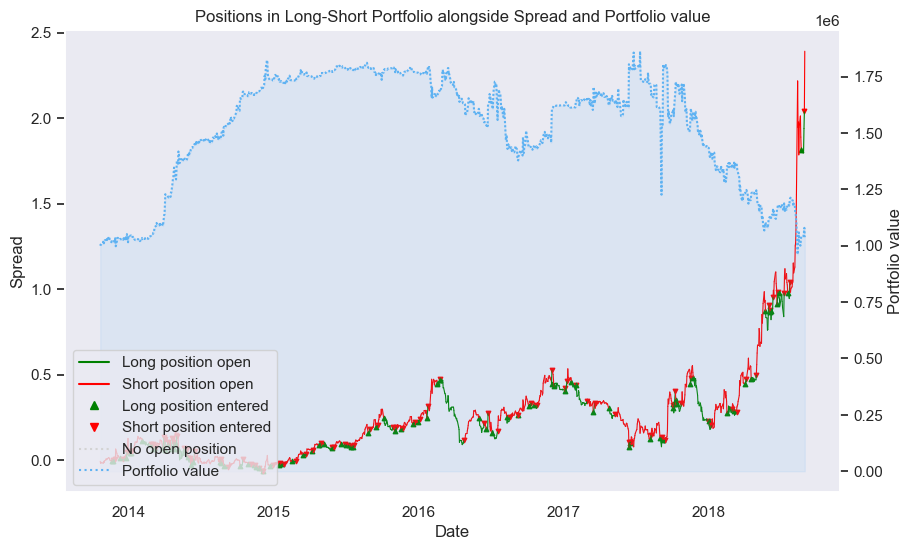

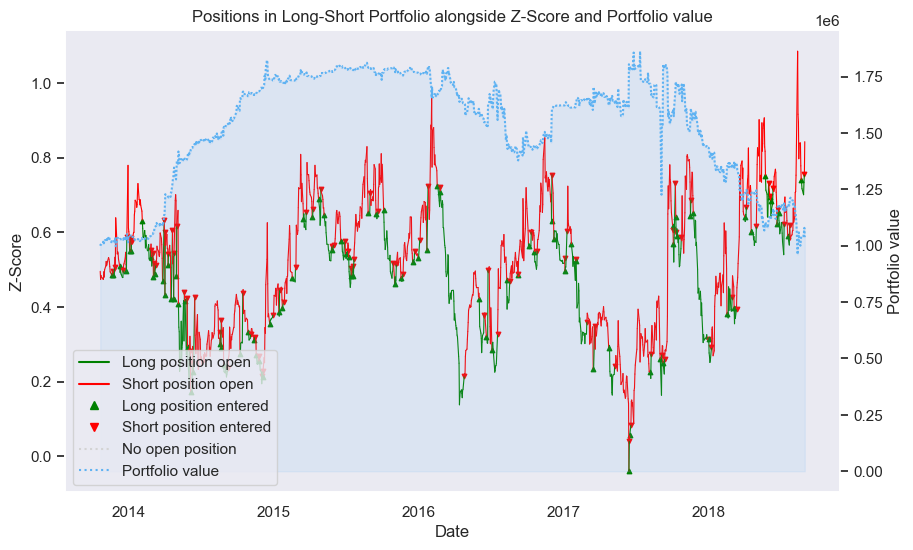

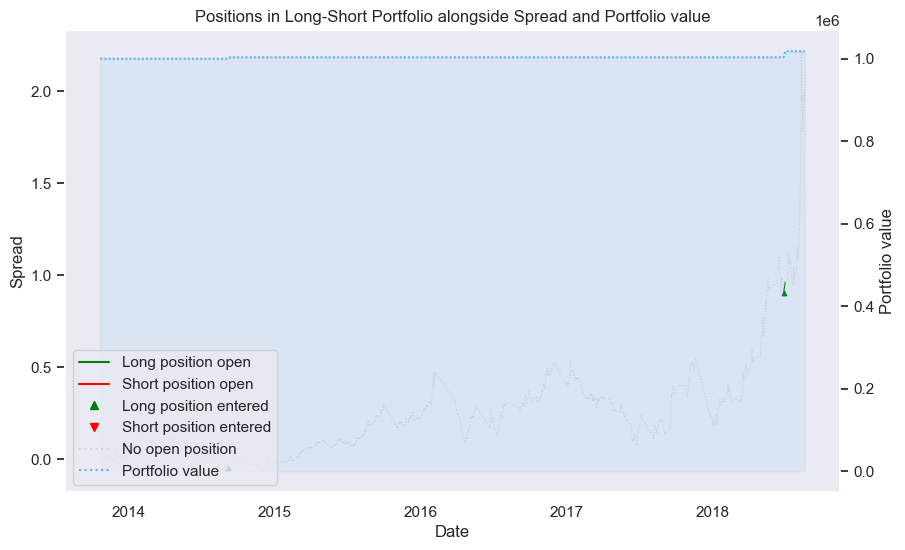

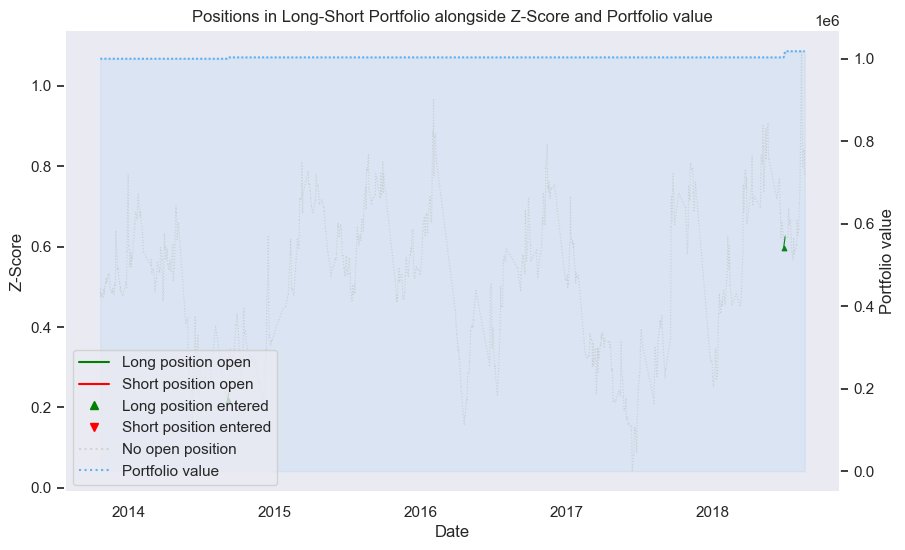

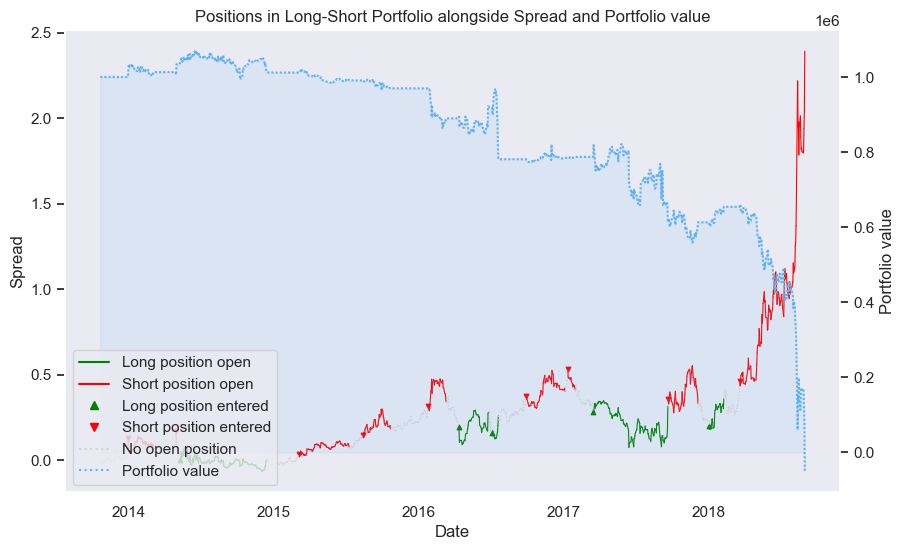

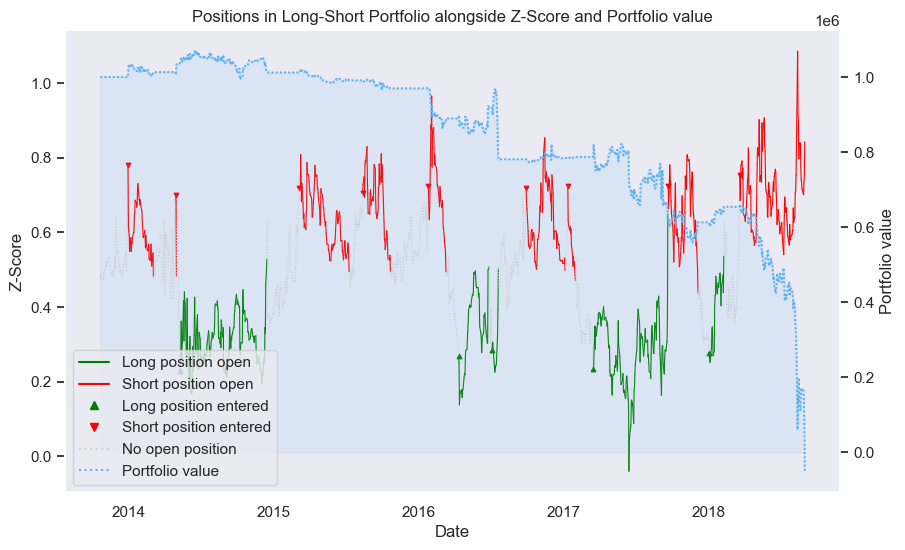

In [82]:
# Generate graphics
benchmarking.plot_neat_portfolio_info(date_range=date_range)
benchmarking.plot_drl_portfolio_info(date_range=date_range)
benchmarking.plot_static_portfolio_info(date_range=date_range)

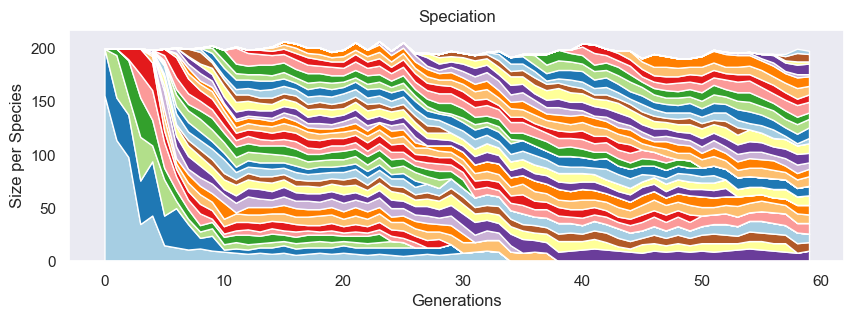

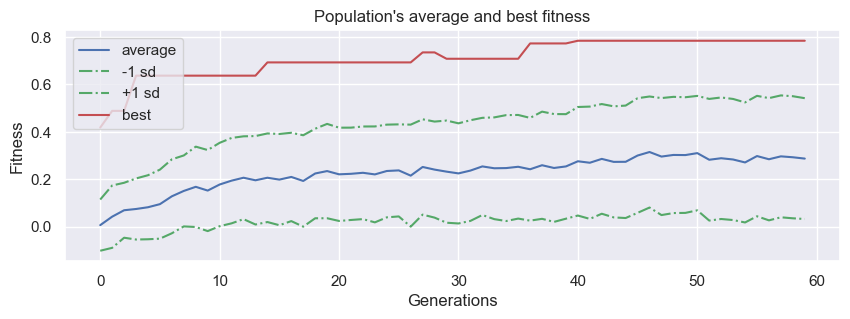

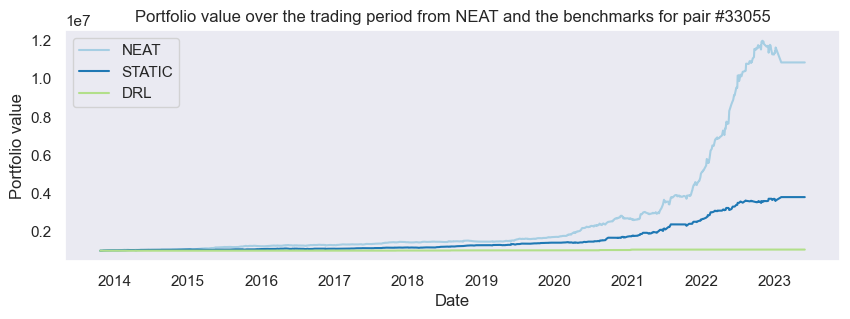

In [11]:

plt.rcParams['figure.figsize'] = (10, 3)

# Plot training stats, speciation and evolved ANN
benchmarking.generate_visuals_neat() 

# Plot wealth comparison
benchmarking.plot_wealth_comparison()


## 4. Generation of remaining plots

In [16]:
plot_frame = comp_frame_test.copy()

Text(0.5, 1.0, 'Out-Of-Sample CAGR for all 61 traded pairs')

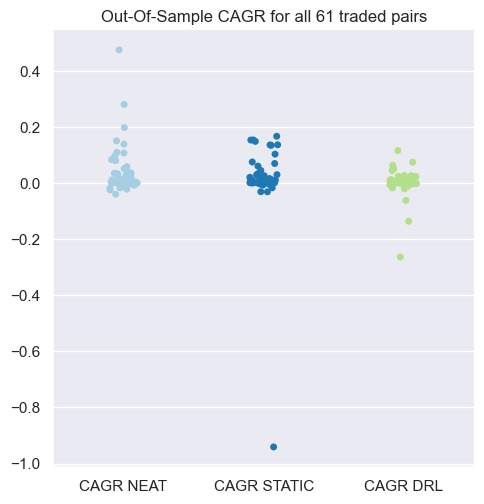

In [17]:
# Horizontal distribution of the scattered dots changes with each plot generation
sns.catplot(data=plot_frame[['CAGR NEAT','CAGR STATIC', 'CAGR DRL']],palette="Paired", kind='strip',height=5, aspect=1, size=5)
plt.title('Out-Of-Sample CAGR for all 61 traded pairs')

Text(0.5, 1.0, 'Out-Of-Sample ASR for all 61 traded pairs')

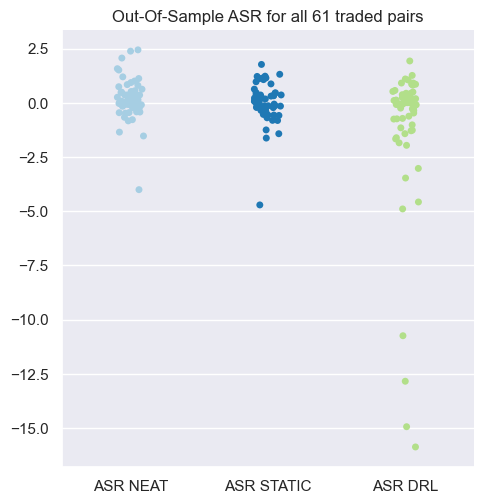

In [18]:
# Horizontal distribution of the scattered dots changes with each plot generation 
sns.catplot(data=plot_frame[['ASR NEAT','ASR STATIC', 'ASR DRL']],palette="Paired", kind='strip',height=5, aspect=1, size=5)
plt.title('Out-Of-Sample ASR for all 61 traded pairs')

Working on column: CAGR NEAT
0.27284034130315055
Working on column: CAGR STATIC
0.40610960067971313
Working on column: CAGR DRL
0.14169962283230395


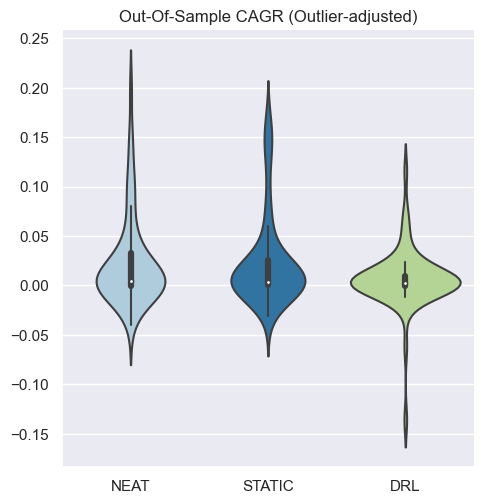

In [19]:
# Prepare data for plotting and remove outliers (3 standard deviations away from the mean)
plot_data = comp_frame_test.copy()
final_mapping_subset = final_mapping[['pair', 'case', 'area_x']]
final_mapping_subset = final_mapping_subset.rename(columns={'case': 'Bucket'})
plot_data = plot_data.merge(final_mapping_subset, on='pair')
plot_data = plot_data[['CAGR NEAT', 'CAGR DRL', 'CAGR STATIC', 'pair', 'Bucket', 'area_x']]
plot_data = remove_outliers(plot_data, ['CAGR NEAT', 'CAGR STATIC', 'CAGR DRL'], 3)
plot_data = plot_data.rename(columns={'CAGR NEAT': 'NEAT', 'CAGR DRL': 'DRL', 'CAGR STATIC': 'STATIC'})

# Generate a violin plot
sns.catplot(data=plot_data[['NEAT', 'STATIC', 'DRL']], palette="Paired", kind='violin')
plt.title('Out-Of-Sample CAGR (Outlier-adjusted)')
plt.show()

Working on column: ASR NEAT
2.940256303130097
Working on column: ASR STATIC
2.1058629819865264
Working on column: ASR DRL
9.592588396612939


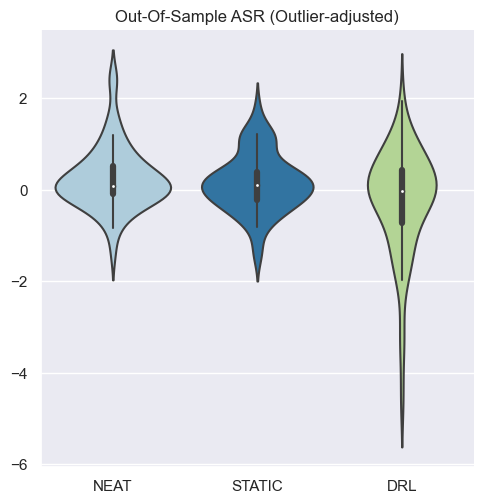

In [20]:
# Prepare data for plotting and remove outliers (3 standard deviations away from the mean)
plot_data = comp_frame_test.copy()
final_mapping_subset = final_mapping[['pair', 'case', 'area_x']]
final_mapping_subset = final_mapping_subset.rename(columns={'case': 'Bucket'})
plot_data = plot_data.merge(final_mapping_subset, on='pair')
plot_data = plot_data[['ASR NEAT', 'ASR DRL', 'ASR STATIC', 'pair', 'Bucket', 'area_x']]
plot_data = remove_outliers(plot_data, ['ASR NEAT', 'ASR STATIC', 'ASR DRL'], 3)
plot_data = plot_data.rename(columns={'ASR NEAT': 'NEAT', 'ASR DRL': 'DRL', 'ASR STATIC': 'STATIC'})

# Generate a violin plot for out-of-sample ASR (adjusted for outliers)
sns.catplot(data=plot_data[['NEAT', 'STATIC', 'DRL']], palette="Paired", kind='violin')
plt.title('Out-Of-Sample ASR (Outlier-adjusted)')
plt.show()

Working on column: CAGR NEAT
0.27284034130315055
Working on column: CAGR STATIC
0.40610960067971313
Working on column: CAGR DRL
0.14169962283230395


Text(0.5, 1.0, 'CAGR of different buckets for NEAT and the benchmark models')

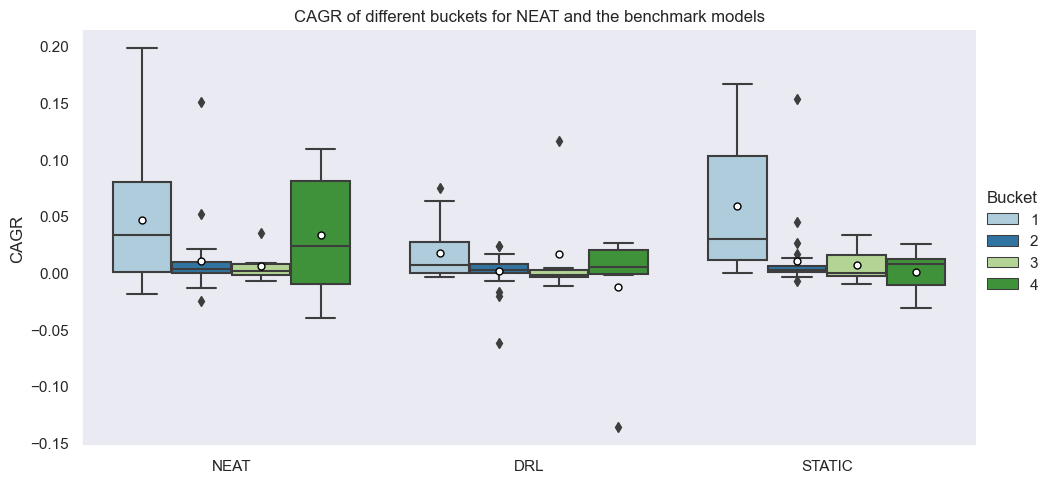

In [54]:
# Prepare data for plotting and remove outliers (3 standard deviations away from the mean)
plot_data = comp_frame_test.copy()

# Prepare the final mapping data
final_mapping_subset = final_mapping[['pair', 'case', 'area_x']]
final_mapping_subset = final_mapping_subset.rename(columns={'case': 'Bucket'})

# Merge data for plotting
merged_data = plot_data.merge(final_mapping_subset, on='pair')
plot_data_subset = merged_data[['CAGR NEAT', 'CAGR DRL', 'CAGR STATIC', 'pair', 'Bucket', 'area_x']]

# Remove outliers from the plot data
plot_data_no_outliers = remove_outliers(plot_data_subset, ['CAGR NEAT', 'CAGR STATIC', 'CAGR DRL'], 3)
plot_data_no_outliers = plot_data_no_outliers.rename(columns={'CAGR NEAT': 'NEAT', 'CAGR DRL': 'DRL', 'CAGR STATIC': 'STATIC'})

# Melt the data for plotting
melted_data = pd.melt(plot_data_no_outliers, value_vars=['NEAT', 'DRL', 'STATIC'],
                      var_name='Model', value_name='CAGR', id_vars=['area_x', 'Bucket'])

# Generate a box plot with detailed annotations
sns.catplot(data=melted_data, x="Model", y="CAGR", legend='brief', palette=sns.color_palette("Paired", 4),
            kind='box', hue='Bucket', height=5, aspect=2, showmeans=True,
            meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 5})

plt.xlabel('')
plt.title('CAGR of different buckets for NEAT and the benchmark models')


Working on column: ASR NEAT
2.940256303130097
Working on column: ASR STATIC
2.1058629819865264
Working on column: ASR DRL
9.592588396612939


Text(0.5, 1.0, 'ASR of different buckets for NEAT and the benchmark models')

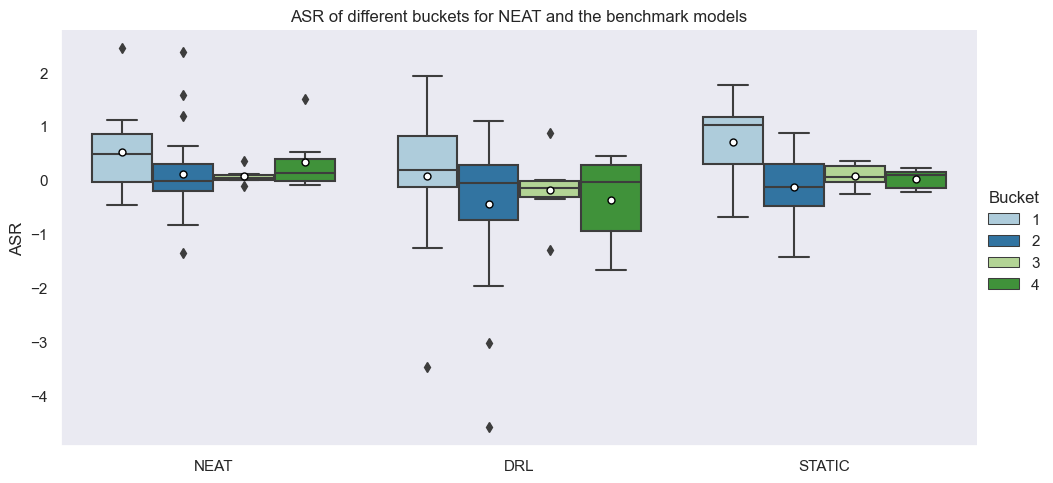

In [38]:
# Prepare data for plotting and remove outliers (3 standard deviations away from the mean)
plot_data = comp_frame_test.copy()

# Prepare the final mapping data
final_mapping_subset = final_mapping[['pair', 'case', 'area_x']]
final_mapping_subset = final_mapping_subset.rename(columns={'case': 'Bucket'})

# Merge data for plotting
merged_data = plot_data.merge(final_mapping_subset, on='pair')
plot_data_subset = merged_data[['ASR NEAT', 'ASR DRL', 'ASR STATIC', 'pair', 'Bucket', 'area_x']]

# Remove outliers from the plot data
plot_data_no_outliers = remove_outliers(plot_data_subset, ['ASR NEAT', 'ASR STATIC', 'ASR DRL'], 3)
plot_data_no_outliers = plot_data_no_outliers.rename(columns={'ASR NEAT': 'NEAT', 'ASR DRL': 'DRL', 'ASR STATIC': 'STATIC'})

# Melt the data for plotting
melted_data = pd.melt(plot_data_no_outliers, value_vars=['NEAT', 'DRL', 'STATIC'],
                      var_name='Model', value_name='ASR', id_vars=['area_x', 'Bucket'])

# Generate a box plot with detailed annotations
sns.catplot(data=melted_data, x="Model", y="ASR", legend='brief', palette=sns.color_palette("Paired", 4),
            kind='box', hue='Bucket', height=5, aspect=2, showmeans=True,
            meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 5})

plt.xlabel('')
plt.title('ASR of different buckets for NEAT and the benchmark models')


Working on column: CAGR NEAT
0.27284034130315055
Working on column: CAGR STATIC
0.40610960067971313
Working on column: CAGR DRL
0.14169962283230395


Text(0.5, 1.0, 'Performance of pairs involving lumber futures with differing expiry dates across models')

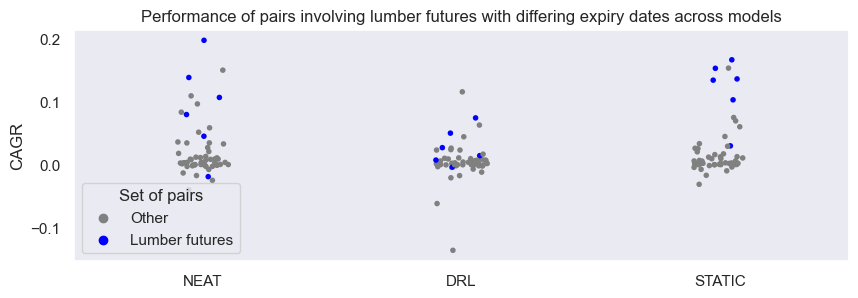

In [37]:
import numpy as np

# Prepare data for plotting and remove outliers (3 standard deviations away from the mean)
plot_data = comp_frame_test.copy()

# Prepare the final mapping data
final_mapping_subset = final_mapping[['pair', 'case', 'area_x']]
final_mapping_subset = final_mapping_subset.rename(columns={'case': 'Bucket'})

# Merge data for plotting
merged_data = plot_data.merge(final_mapping_subset, on='pair')
plot_data_subset = merged_data[['CAGR NEAT', 'CAGR DRL', 'CAGR STATIC', 'pair', 'Bucket', 'area_x']]

# Remove outliers from the plot data
plot_data_no_outliers = remove_outliers(plot_data_subset, ['CAGR NEAT', 'CAGR STATIC', 'CAGR DRL'], 3)
plot_data_no_outliers = plot_data_no_outliers.rename(columns={'CAGR NEAT': 'NEAT', 'CAGR DRL': 'DRL', 'CAGR STATIC': 'STATIC'})

# Melt the data for plotting
melted_data = pd.melt(plot_data_no_outliers, value_vars=['NEAT', 'DRL', 'STATIC'],
                      var_name='Model', value_name='CAGR', id_vars=['area_x', 'Bucket'])

# Map area_x values to meaningful categories
melted_data['area_x'] = np.where(melted_data['area_x'] == 'Futures on lumber (Pairs combine different expiries)', 'Lumber futures', 'Other')
melted_data = melted_data.rename(columns={'area_x': 'Set of pairs'})

# Generate plot with highlighted categories
highlighted_categories = ['Lumber futures']
color_palette = {'Other': 'grey', 'Lumber futures': 'blue'}
sns.stripplot(data=melted_data, x="Model", y="CAGR", hue='Set of pairs', palette=color_palette, legend='brief', size=4, jitter=True)

plt.xlabel('')
plt.title('Performance of pairs involving lumber futures with differing expiry dates across models')